# CIFAR-10 이미지 생성하기 

# Step1. 라이브러리 불러오기

In [72]:
import tensorflow as tf
import imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import PIL
from tensorflow.keras import layers
from IPython import display
import os
from matplotlib.pylab import rcParams

# Step2. 데이터셋 구성하기
tf.keras안에 있는 CIFAR-10을 불러옵시다.

In [73]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape, test_x.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

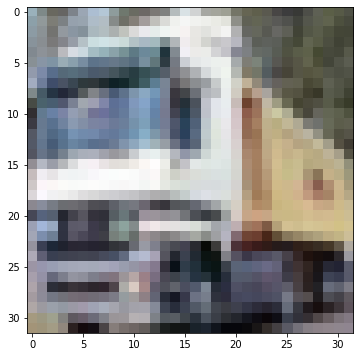

In [74]:
plt.imshow(train_x[1])

train_x의 이미지를 (-1,1)로 정규화시켜줍니다.

In [75]:
print(train_x.max())
print(train_x.min())

255
0


In [76]:
train_x = (train_x - 127.5) / 127.5
print(train_x.max())
print(train_x.min())

1.0
-1.0


어떻게 생겼는지 한번 꺼내서 출력해봅시다.

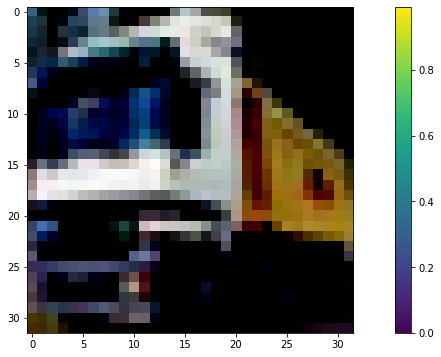

In [77]:
plt.imshow(train_x[1])
plt.colorbar()

너무 많은 양을 한번에 학습시키면 메모리 활용면에서도 비효율적이기때문에, 미니배치학습을 시켜주겠습니다.
그리고 텐서플로우 딥러닝 모델은 tensor형태의 데이터를 입력으로 받기때문에, 데이터를 dataset으로 변환시켜줍니다. - from_tensor_slices()사용

In [78]:
BUFFER_SIZE = 50000 # 전체데이터를 섞기위해 50000으로 설정합니다.
BATCH_SIZE = 256 # 모델이 한번에 학습할 데이터의 양입니다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Step3. 생성자 모델 구현하기
우리가 구현해 볼 모델은 DCGAN(Deep Convolutional GAN)의 생성자 모델입니다. 

In [79]:
def make_generator_model():
  # Start
  model = tf.keras.Sequential()

  # Frist: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Second: Reshape layer
  model.add(layers.Reshape((8,8,256)))

  # Third: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Fifth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  return model

generator = make_generator_model()
generator.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_33 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_12 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_34 (Bat  (None, 8, 8, 128)      

모델이 만들어졌으니 이제 shape=(1, 100)의 형상을 가지는 램덤 노이즈 벡터를 생성해서 결과물을 한번 출력해봅시다.

In [80]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

원하는 사이즈의 결과물이 나왔네요 그럼한번 시각화해봅시다.

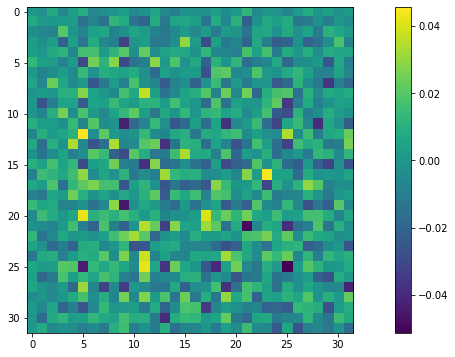

In [81]:
plt.imshow(generated_image[0,:,:,0])
plt.colorbar()

아직은 모델이 전혀 학습하지 않은 상태이기때문에 아무런 의미가 없는 이미지가 생성되었습니다.

# Step4. 판별자 모델 구현하기
판별자는 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야합니다.

In [82]:
def make_discriminator_model():
  # Start
  model = tf.keras.Sequential()

  # First: Conv2D layer
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Second: Conv2D layer
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Third: Flatten layer
  model.add(layers.Flatten())

  # Fourth: Dense layer
  model.add(layers.Dense(1))

  return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 8192)            

이전에 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올지 확인해봅시다.

In [83]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00091918]], dtype=float32)>

# Step5. 손실함수와 최적화함수 구현하기
# 손실함수(loss function)
GAN은 손실함수로 Cross Entropy를 사용합니다. 그리고 여기서는 판별자가 한개의 이미지가 가짜인지 진짜를 분류해야하는 문제이므로 이진교차엔트로피를 사용할 것입니다.

그렇다면 진짜이미지에 대한 라벨을 1, 가짜이미지에 대한 라벨을 0으로 두었을때 목표는 다음과 같습니다.
- 생성자 : 판별자가 가짜이미지에 대해 판별한 값이 1에 가까워지는것
- 판별자 : 진짜 이미지 판별값이 1, 가짜 이미지 판별값이 0에 가까워지는것

from_logits을 True로 설정해주어야 이진교차엔트로피에 입력된 값을 함수 내부에서 시그모이드함수를 사용해 0~1사이의 값으로 정규화한 후에 알맞게 계산할 수 있습니다.

In [84]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [85]:
# generator_loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator_loss 
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

한편 판별자가 real output,fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는것도 GAN학습에서 매우 중요합니다. 

여기서 가장 이상적인 상황은 real accuracy와 fake accuracy가 초반에는 1에가깝게 나오다가, 서서히 낮아져서 둘다 0.5에 가까워지는 것이 이상적입니다. 

In [86]:
# tf.math.greater_equal() : 특정상수보다 높으면 True, False로 판별,
# tf.cast() : True는 1.0, False는 0.0으로 반환
# tf.reduce_mean() : 값들을 평균내어 하나의 값으로 반환
def discriminator_accuracy(real_output, fake_output):
  real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
  fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
  return real_accuracy, fake_accuracy

# 최적화함수(Optimizer)
여기서는 Adam을 사용하겠습니다.

중요한점은 생성자와 판별자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [87]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 16장을 생성하고, 생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다. 즉, 100차원의 노이즈를 총 16개, (16,100)형상의 벡터를 만들어 두도록 하겠습니다.

In [88]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# Step6. 훈련과정 상세기능 구현하기
하나의 미니배치 당 진행할 train_step함수를 만들어봅시다. 그리고 함수위에 @tf.function데코레이터를 사용해주면, 함수의 입력데이터가 Tensorflow의 graph노드가 될 수 있는 타입으로 자동 변환됩니다. 

In [89]:
@tf.function
def train_step(images): # (1) 입력데이터
  noise = tf.random.normal([BATCH_SIZE, noise_dim]) # (2) 생성자 입력 노이즈
 
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # (3) tf.GradientTape() 오픈
    generated_images = generator(noise, training=True) # (4) generated_images 생성

    # (5) discriminator 판별
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # (6) loss 계산
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    # (7) accuracy 계산
    real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

  # (8) gradient 계산
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # (9) 모델 학습
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss, real_accuracy, fake_accuracy # (10) 리턴값

- (1) 입력데이터 : Real image 역할을 할 images한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images한 세트와 같은 크기인 BATCH_SIZE만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동미분으로 계산하기위해 with 구문열기
- (4) generated_images생성 : generator가 noise를 입력받은후 generated_images생성
- (5) discriminator판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator각각의 loss계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

In [90]:
def generate_and_save_images(model, epoch, it, sample_seeds):

  predictions = model(sample_seeds, training=False)

  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0])
    plt.axis('off')

  plt.savefig('/content/drive/MyDrive/Exploration_Data/ex11/generated_samples/sample_epoch_{:04d}_iter_{:3d}.png'.format(epoch, it))
  plt.show()

훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.

In [91]:
rcParams['figure.figsize'] = 15,6

def draw_train_history(history, epoch):
  # summarize history for loss
  plt.subplot(211)
  plt.plot(history['gen_loss'])
  plt.plot(history['disc_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('batch iters')
  plt.legend(['gen_loss', 'disc_loss'], loc='upper left')

  # summarize history for accuracy
  plt.subplot(212)
  plt.plot(history['fake_accuracy'])
  plt.plot(history['real_accuracy'])
  plt.title('discriminator accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('batch iters')
  plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

  # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
  plt.savefig('/content/drive/MyDrive/Exploration_Data/ex11/training_history/train_history_{:04d}.png'.format(epoch))
  plt.show()

training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [92]:
checkpoint_dir = '/content/drive/MyDrive/Exploration_Data/ex11/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Step7. 학습 과정 진행하기

이제 진짜 학습을 진행해보겠습니다.

In [93]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [94]:
save_every = 5
EPOCHS = 50

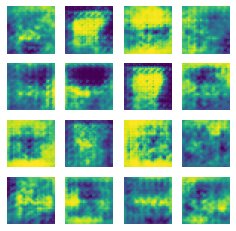

Time for training : 773 sec


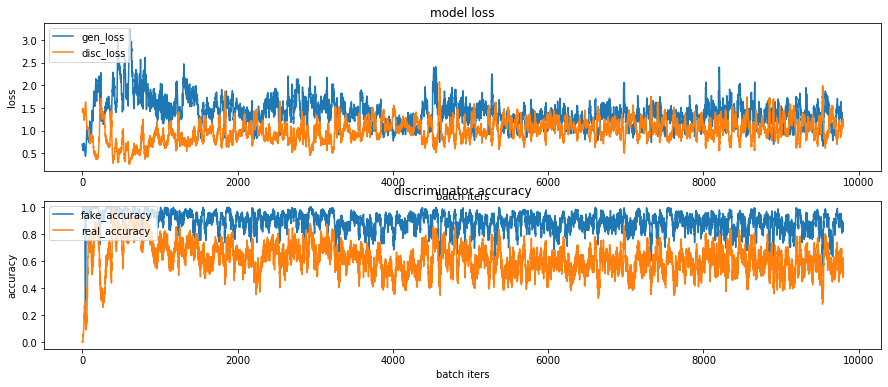

CPU times: user 13min 7s, sys: 9.72 s, total: 13min 17s
Wall time: 12min 54s


In [95]:
%%time
train(train_dataset, EPOCHS, save_every)

fake accuracy가 여전히 좋지 않네요. 이는 판별자가 fake이미지를 잘 구별하고 있다는 말이기도 하지만, 생성자가 이미지를 제대로 못만들어냈다는 말이기도합니다. 다른방법을 사용해보겠습니다.

# Step8. GAN 훈련과정 개선하기
학습률을 좀더 높여서 진해보겠습니다.

In [96]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

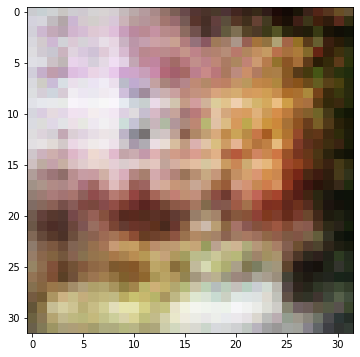

In [97]:
# 학습해둔 모델을 로드해서 학습을 이어서 하겠습니다.
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅시다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()

checkpoint 모델이 로드되었으므로 훈련을 재개해봅시다.

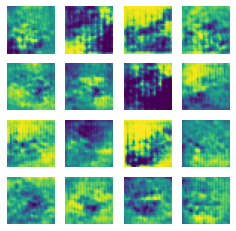

Time for training : 772 sec


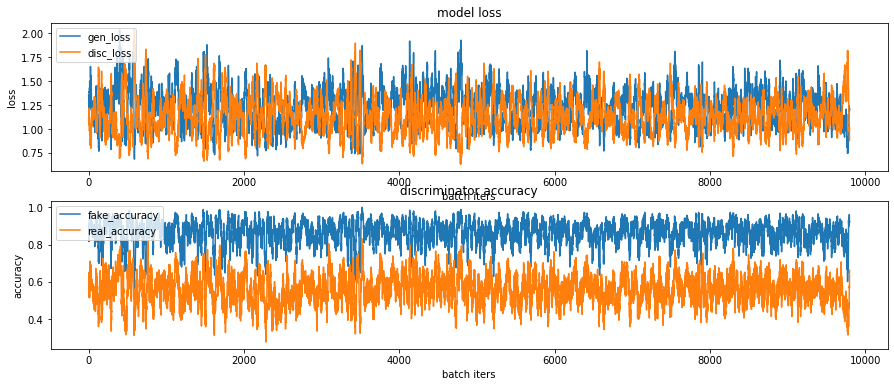

CPU times: user 13min 9s, sys: 6.39 s, total: 13min 15s
Wall time: 12min 53s


In [99]:
%%time
train(train_dataset, EPOCHS, save_every)

별진전이 없네요. 이번에는 학습률은 원래대로 돌리고,생성자의 활성화함수로 ReLU를 사용해보겠습니다.

In [100]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [101]:
def make_generator_model():
  # Start
  model = tf.keras.Sequential()

  # Frist: Dense layer
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # Second: Reshape layer
  model.add(layers.Reshape((8,8,256)))

  # Third: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # Fourth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  # Fifth: Conv2DTranspose layer
  model.add(layers.Conv2DTranspose(3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

  return model

generator = make_generator_model()
generator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_36 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_37 (Bat  (None, 8, 8, 128)      

In [102]:
# 학습해둔 모델을 로드해서 학습을 이어서 하겠습니다.
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

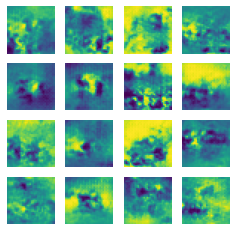

Time for training : 773 sec


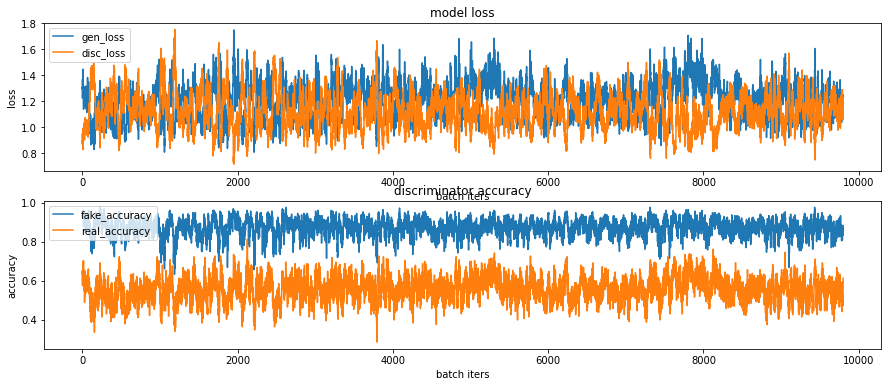

CPU times: user 13min 8s, sys: 8.64 s, total: 13min 16s
Wall time: 12min 54s


In [103]:
%%time
train(train_dataset, EPOCHS, save_every)

# 회고
- 이번 실습에서는 DCGAN을 사용했다. 생성자는 판별자를 속이려하고, 판별자는 가짜이미지를 찾아내려고하는 구조가 재밌는것같다. 
- 학습과정에 생성자가 생성해내는 이미지를 실시간으로 볼 수 있었어서 어떤식으로 학습이 이루어지는지 눈으로 확인할 수 있었다.
- 하지만 생성자가 이미지를 제대로 생성하지 못했던것같아, 몇 가지 다른 시도를했다. 학습률을 올려서 진행하거나 생성자 모델의 활성화함수를 ReLU로 바꿔서 진행해보았지만 여전히 fake accuracy값이 높았다. 총 에포크가 150회 진행되었음에도 진전이없었다.. 시각화된 이미지는 확실히 에포크가 진행됨에 따라 무언가를 확실히 그리는것같아보였다. 하지만 뭘 그리는지...